In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import logging
import networkx as nx
import os
import h5py
import matplotlib.pyplot as plt
import torch.optim as optim
import time
import math
import os, sys
import seaborn as sns
import warnings
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
# from MaxMin_Norm import MinMaxNormalization
from torch.utils.data import TensorDataset, DataLoader
sys.path.append('../data_process/')
warnings.filterwarnings("ignore")
import pickle

In [2]:
class SE_Block(nn.Module):
    def __init__(self, in_channel, reduction=16):
        super(SE_Block, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # 全局自适应池化
        self.fc = nn.Sequential(
            nn.Linear(in_channel, in_channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channel // reduction, in_channel, bias=False),
            nn.Sigmoid()
        )
 
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c) # squeeze操作
        y = self.fc(y).view(b, c, 1, 1) # FC获取通道注意力权重，是具有全局信息的
        return x * y.expand_as(x) # 注意力

In [3]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)



    def forward(self, input_tensor, cur_state):
#         print(input_tensor.shape)
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        combined_conv = self.conv(combined)
   
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))
class ConvLSTM(nn.Module):

    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
#         if not self.batch_first:
#             print(1)
#             # (t, b, c, h, w) -> (b, t, c, h, w)
#             input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()
        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states
      
    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [4]:
class ResUnit(nn.Module):
    def __init__(self, in_channels, out_channels, lng, lat):
        # 模型的输入是一个四维张量 (B, C, lng, lat)
        super(ResUnit, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
#         self.MPAttention = MPAttention(80,32,32)
        # 分别定义两个批归一化层和卷积层
    def forward(self, x):
        z = F.relu(self.bn1(x))
        z = self.conv1(z)
        z = F.relu(self.bn2(z))
        z = self.conv2(z)
        out = x+z
        return out 


In [5]:
class Branch_net(nn.Module):
    def __init__(self, num_res_unit, input_lenght, flow_channel, grid_heigh, grid_width,in_channels):
        super(Branch_net, self).__init__()
        self.num_res_unit = num_res_unit
        self.input_lenght = input_lenght
        self.flow_channel = flow_channel
        self.grid_heigh = grid_heigh
        self.grid_width = grid_width
        self.in_channels = in_channels
        # 每个分支网络的首部都是用一个卷积网络将输入的特征维度从低维映射到高维
#         self.branch_net = nn.ModuleList([SE_Block(26)])
        
        self.branch_net = nn.ModuleList([ResUnit(64, 64, self.grid_heigh, self.grid_width)])
#         nn.ModuleList([nn.Conv2d(self.in_channels, 80, kernel_size=3, stride=1, padding=1)])
#         self.branch_net.append(nn.Conv2d(self.in_channels, 80, kernel_size=3, stride=1, padding=1))
        # 接下来依次添加多个残差卷积单元
        for i in range(3): 
            self.branch_net.append(ResUnit(64, 64, self.grid_heigh, self.grid_width))
#             self.branch_net.append(ResUnit1(80, 80, self.grid_heigh, self.grid_width))
        # 每个分支网络的尾部都是用一个卷积网络将输入的特征维度从高维映射到原本的维度
#         self.branch_net.append(CoordAtt(80,80,32))
#         self.branch_net.append(nn.Conv2d(80, 2, kernel_size=3,stride = 1, padding = 1))
        
    # 分支网络的前向传播
    def forward(self, x):
        for layer in self.branch_net:
             x = layer(x)
        return x 

In [6]:
class Model(nn.Module):
    def __init__(self,lr=0.01,epoch=10, #训练轮次数
                 batch_size=32, #批训练batch大小
                 c_length=6, #邻近性时间流量特征序列默认长度
                 p_length=1, #周期性时间流量特征序列默认长度
                 t_length=1,  #趋势性时间流量特征序列默认长度
                 external_dim=28, #外部特征的维度
                 grid_heigh=16, #网格图的高度
                 grid_width=8, #网格图的宽度
                 flow_channel=2, #流量种类
                 num_res_unit=2, #设定残差卷积单元的数量
                 in_channels = 6,
                 data_min = -10000,  # 输入数据的最小值默认值
                 data_max = 10000):
        super(Model, self).__init__()
        self.epoch = epoch  
        self.lr = lr
        self.batch_size = batch_size
        self.c_length = c_length
        self.p_length = p_length
        self.t_length = t_length
        self.external_dim = external_dim
        self.grid_heigh = grid_heigh
        self.grid_width = grid_width
        self.flow_channel  = flow_channel 
        self.num_res_unit = num_res_unit
        self.logger = logging.getLogger(__name__)
        self.data_min = data_min
        self.data_max = data_max
        self.gpu_available = torch.cuda.is_available()
        if self.gpu_available:  #如果GPU存在，则调用
            self.gpu = torch.device("cuda:0")
        self.backbone_net()
        self.save_path="L%d_C%d_P%d_T%d/"% (self.num_res_unit,self.c_length, self.p_length, self.t_length)
        self.best_mse = 10000
    def backbone_net(self):
        self.c_net = Branch_net(self.num_res_unit,self.c_length,
                     self.flow_channel, self.grid_heigh, self.grid_width,64) 
        self.c_net1 = Branch_net(self.num_res_unit,self.c_length,
                     self.flow_channel, self.grid_heigh, self.grid_width,64)
        self.conv3D1 = nn.Conv3d(2, 32, kernel_size=(3,3,3), stride=1, padding='same')
        self.conv3D11 = nn.Conv3d(32, 2, kernel_size=(3,3,3), stride=1, padding='same')
        self.conv3D2 = nn.Conv3d(2, 8, kernel_size=(3,3,3), stride=1, padding='same')
        self.conv3D22 = nn.Conv3d(8, 2, kernel_size=(3,3,3), stride=1, padding='same')
        self.ConvLSTM_C = ConvLSTM(input_dim=2,hidden_dim=2, kernel_size=(3,3), num_layers=1,
                 batch_first=False, bias=True, return_all_layers=False)

        self.ConvLSTM_P = ConvLSTM(input_dim=2,hidden_dim=4, kernel_size=(3,3), num_layers=1,
                 batch_first=False, bias=True, return_all_layers=False)
        self.SENet1 = SE_Block(64)
        self.SENet2 = SE_Block(64)
        self.conv1 = nn.Conv2d(12, 64, 3, 1, 1)
        self.conv11 = nn.Conv2d(64, 2, 1, 1, 0)
        self.conv2 = nn.Conv2d(4, 64, 3, 1, 1)
        self.conv22= nn.Conv2d(64, 2, 1, 1, 0)
        self.w_c = nn.Parameter(torch.randn((self.flow_channel,
                self.grid_heigh, self.grid_width)), requires_grad=True)
        self.w_p = nn.Parameter(torch.randn((self.flow_channel,
                self.grid_heigh, self.grid_width)), requires_grad=True)
        self.ext_net = nn.Sequential(
            nn.Linear(9, 15), 
            nn.ReLU(inplace = True),
            nn.Linear(15,2*self.grid_heigh*self.grid_width))
    def forward(self, xc, xp, xt,ext):

        ext_out = self.ext_net(ext).view([-1, 2,
                                          self.grid_heigh, self.grid_width])
        xcin = xc[:,:11:2,:,:]
        xcin = xcin.reshape(-1,1,6,16,8)
        xcout = xc[:,1:12:2,:,:]
        xcout = xcout.reshape(-1,1,6,16,8)
        Xc = torch.cat((xcin,xcout),1)
        Xc = self.conv3D1(Xc)
        Xc = self.conv3D11(Xc) #Xc [32,2,6,32,32]
        Xc = Xc.permute(0, 2, 1, 3, 4)
        Xc1,Xc2 = self.ConvLSTM_C(Xc)
        Xc1  =Xc1.reshape(-1,12,16,8)
        Xc1  = self.conv1(Xc1)
        Xc1 = self.c_net(Xc1)
# #         Xc1 = self.SENet1(Xc1)
        Xc1 = self.conv11(Xc1)
#         xpin = xp[:,2:3,:,:]
#         xpin = xpin.unsqueeze(2)
#         xpout = xp[:,3:4,:,:]
#         xpout = xpout.unsqueeze(2)
#         Xp = torch.cat((xpin,xpout),1)
#         Xp = self.conv3D1(Xp)
#         Xp = self.conv3D11(Xp) #Xc [32,2,6,32,32]
#         Xp = Xp.permute(0, 2, 1, 3, 4)
#         Xp1,Xp2 = self.ConvLSTM_P(Xp)
#         Xp1  =Xp1.reshape(-1,2,32,32)
        xp = torch.cat((xp[:,2:4,:,:],xt[:,2:4,:,:]),1)
        Xp1 = self.conv2(xp)
        Xp1 = self.c_net1(Xp1)
#         Xp1 = self.SENet2(Xp1)
        Xp1 = self.conv22(Xp1)
#         print(Xp1.shape)
        X =Xc1*self.w_c.unsqueeze(0)+Xp1*self.w_p.unsqueeze(0)
        X = X+ext_out    
        return X
    def train_model(self, train_loader, val_loader):
        optimizer = optim.Adam(self.parameters(),lr = self.lr)
        loss_func = nn.MSELoss() # 定义模型的优化器和损失函数
#         loss_func = nn.L1Loss(size_average=None, reduce=None, reduction='mean')
        early_stop_threshold = 10 # 设定提前停止阈值
        epoch_count = 0
        start_time = time.time()
        for ep in range(self.epoch):
            loss_list = []
            self.train() # 启动模型训练
            for i, (xc, xp, xt, xe,y) in enumerate(train_loader):
                if self.gpu_available:
                    xc = xc.to(self.gpu)
                    xp = xp.to(self.gpu)
                    xt = xt.to(self.gpu)
                    xe = xe.to(self.gpu)
                    y = y.to(self.gpu)
                ypred = self.forward(xc, xp, xt, xe)
                loss = loss_func(ypred, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # 模型验证部分，根据验证集上的损失保存最优模型
            for i, (xc, xp, xt, xe, y) in enumerate(val_loader):
                if self.gpu_available:
                    xc = xc.to(self.gpu)
                    xp = xp.to(self.gpu)
                    xt = xt.to(self.gpu)
                    xe = xe.to(self.gpu)
                    y = y.to(self.gpu)
                ypred = self.forward(xc, xp, xt, xe)
#                 y = y.reshape(-1,2,1024)
#                 y = y.reshape(-1,1024,2)
                val_loss = loss_func(ypred, y)
                loss_list.append(val_loss.item())
                end_time = time.time() 
            val_mse = np.mean(loss_list)
            print("[%.2fs] ep %d val mse %.6f" %(end_time - start_time, ep, val_mse))
            if val_mse < self.best_mse: #保存当前更优模型参数
#                 self.save_model("3D-ConvLSTMNet-BikeNYC")
                self.best_mse = val_mse
                epoch_count = 0
            else:
                epoch_count = epoch_count +1
#             if epoch_count >= early_stop_threshold:
#                 break  # 当超过提前停止阈值时整个循环结束
            self.eval()
            for i, (xc, xp, xt, xe,y) in enumerate(test_loader):
                if self.gpu_available:
                    xc = xc.to(self.gpu)
                    xp = xp.to(self.gpu)
                    xt = xt.to(self.gpu)
                    xe = xe.to(self.gpu)
                    y = y.to(self.gpu)
                with torch.no_grad():
                    ypred = self.forward(xc, xp, xt, xe)
                # 采用RMSE和MAE作为模型评估的指标
#                 rmse = ((ypred - y) **2).mean().pow(1/2)
#                 mae = ((ypred - y).abs()).mean()
#                 # 将RMSE和MAE恢复到规范化之前的尺度
#                 rmse = rmse * (self.data_max - self.data_min)
#                 mae = mae * (self.data_max - self.data_min)
#                 rmse_list.append(rmse.item())
#                 mae_list.append(mae.item())
                ypred = ypred.cpu().numpy()
                y = y.cpu().numpy()
                if i == 0:
                    ypred1 = ypred
                    y1 = y
                else:
                    y1 = np.concatenate((y1,y),axis=0)
                    ypred1 = np.concatenate((ypred1,ypred),axis=0)
            y = [inverse_transform(d) for d in y1]
            ypred = [inverse_transform(d) for d in ypred1]
            y1 = np.array(y).reshape(43008)
            ypred1 = np.array(ypred).reshape(43008)
            print(np.sqrt(metrics.mean_squared_error(ypred1, y1)))
            print(metrics.mean_absolute_error(ypred1, y1))
            LISTRMSE.append(np.sqrt(metrics.mean_squared_error(ypred1, y1)))
            LISTMAE.append(metrics.mean_absolute_error(ypred1, y1))
    def test_model(self, test_loader):
        rmse_list = []
        mae_list = []
        self.eval() # 启动模型评估（固定BN层参数）
        for i, (xc, xp, xt, xe,y) in enumerate(test_loader):
            if self.gpu_available:
                xc = xc.to(self.gpu)
                xp = xp.to(self.gpu)
                xt = xt.to(self.gpu)
                xe = xe.to(self.gpu)
                y = y.to(self.gpu)
            with torch.no_grad():
                ypred = self.forward(xc, xp, xt, xe)
            # 采用RMSE和MAE作为模型评估的指标
            rmse = ((ypred - y) **2).mean().pow(1/2)
            mae = ((ypred - y).abs()).mean()
            # 将RMSE和MAE恢复到规范化之前的尺度
            rmse = rmse * (self.data_max - self.data_min)
            mae = mae * (self.data_max - self.data_min)
            rmse_list.append(rmse.item())
            mae_list.append(mae.item())
            ypred = ypred.cpu().numpy()
            y = y.cpu().numpy()
            if i == 0:
                ypred1 = ypred
                y1 = y
            else:
                y1 = np.concatenate((y1,y),axis=0)
                ypred1 = np.concatenate((ypred1,ypred),axis=0)
        
        mae_test = np.mean(mae_list)
        rmse_test = np.mean(rmse_list)
        return rmse_test, mae_test, ypred1, y1
    
    # 模型保存代码
    def save_model(self, name):
        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)
        torch.save(self.state_dict(), self.save_path + name + ".pkl")
    
    # 读取已保存的模型
    def load_model(self, name):
        if not name.endswith(".pkl"):
            name += ".pkl"
        self.load_state_dict(torch.load(self.save_path + name)) 

In [7]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
gpu_available = torch.cuda.is_available()
print(torch.cuda.is_available())
if gpu_available:
    gpu = torch.device("cuda:0")

cuda
True


In [8]:
LISTRMSE=[]
LISTMAE=[]
def inverse_transform(X):
    X = (X + 1.) / 2.
    X = 1. * X * (267 - 0) + 0
    return X
for i in range(1):
    if __name__ == '__main__':
        logging.basicConfig(level=logging.DEBUG,format='%(levelname)s-%(message)s')
        # 为模型中所有超参数赋值
        epochs = 100  # 训练的轮次数
        batch_size = 32 # 训练批次大小
        T = 48  # 一天内的时间片段划分
        c_length = 6  # 临近性序列长度
        p_length = 1  # 周期性序列长度
        t_length = 1  # 趋势性序列长度
        grid_height, grid_width = 16, 8  # 网格图的规格
        flow_channel = 2 # 流量类别数
        lr = 0.0005  # 学习率
        external_dim = 28 #额外特征维度
        num_res_unit = 2  # 卷积残差单元个数

        # 读取训练,验证和测试数据（分别需读入临近性，周期性，趋势性，额外特征数据已经标签数据）
        c_train =  np.load('BikeNYC/c_train.npy')
        p_train = np.load('BikeNYC/p_train.npy')
        t_train = np.load('BikeNYC/t_train.npy')
        e_train = np.load('BikeNYC/e_train.npy')
        train_y = np.load('BikeNYC/train_y.npy')
        c_val =  np.load('BikeNYC/c_val.npy')
        p_val = np.load('BikeNYC/p_val.npy')
        t_val = np.load('BikeNYC/t_val.npy')
        e_val = np.load('BikeNYC/e_val.npy')
        val_y = np.load('BikeNYC/val_y.npy')
        c_test = np.load('BikeNYC/c_test.npy')
        p_test = np.load('BikeNYC/p_test.npy')
        t_test = np.load('BikeNYC/t_test.npy')
        e_test = np.load('BikeNYC/e_test.npy')
        test_y = np.load('BikeNYC/test_y.npy')

    #     print(len(P2),len(C3))
        # 读取已保存的归一化数据转换器
        with open ('../data_process/data/preprocessing.pkl', 'rb') as f:
         scale = pickle.load(f)  
    #     print(c_train.shape,p_train.shape,t_train.shape,P.shape,C1.shape)
        # 将训练集/验证集/测试集都整理成pytorch的输入格式
        train_set = TensorDataset(torch.Tensor(c_train),torch.Tensor(p_train),torch.Tensor(t_train), 
                torch.Tensor(e_train), torch.Tensor(train_y))
        val_set = TensorDataset(torch.Tensor(c_val),torch.Tensor(p_val),torch.Tensor(t_val),
               torch.Tensor(e_val), torch.Tensor(val_y))
        test_set = TensorDataset(torch.Tensor(c_test),torch.Tensor(p_test),torch.Tensor(t_test),
               torch.Tensor(e_test),  torch.Tensor(test_y))

        # 装载训练集/验证集/测试集数据
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle = True,drop_last=False)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle = False)
        test_loader = DataLoader(test_set, batch_size=batch_size, shuffle = False,drop_last=False)

        # 定义模型
        net = Model(lr = lr, epoch = epochs, batch_size = batch_size, 
                   c_length = c_length, p_length = p_length, t_length = t_length, 
                   external_dim = external_dim, grid_heigh = grid_height, 
                   grid_width = grid_width, flow_channel = flow_channel, 
                   num_res_unit = num_res_unit, data_min = scale._min, data_max = scale._max)
    #     net = DCANet(lr = lr, epoch = epochs, batch_size = batch_size, 
    #                c_length = c_length, p_length = p_length, t_length = t_length, 
    #                external_dim = external_dim, grid_heigh = grid_height, 
    #                grid_width = grid_width, flow_channel = flow_channel, 
    #                num_res_unit = num_res_unit, data_min = scale._min, data_max = scale._max)
        if gpu_available:
            net = net.to(gpu)
        # 训练模型
        net.train_model(train_loader, val_loader)
        print('test model....')
        net.load_model("3D-ConvLSTMNet-BikeNYC") # 读取最优模型
        rmse, mae,ypred,y  = net.test_model(test_loader) #用验证集上最好的模型进行测试评估
        print('RMSE=', rmse.item(), 'MAE=', mae.item())
        y = [inverse_transform(d) for d in y]
        ypred = [inverse_transform(d) for d in ypred]
        y1 = np.array(y).reshape(43008)
        ypred1 = np.array(ypred).reshape(43008)
        print(np.sqrt(metrics.mean_squared_error(ypred1, y1)))
        print(metrics.mean_absolute_error(ypred1, y1))
        LISTRMSE.append(np.sqrt(metrics.mean_squared_error(ypred1, y1)))
#         LISTMAE.append(metrics.mean_absolute_error(ypred1, y1))

[4.33s] ep 0 val mse 0.015265
15.369409
11.02654
[5.80s] ep 1 val mse 0.008937
11.547977
8.408805
[7.24s] ep 2 val mse 0.006573
9.744562
6.831439


KeyboardInterrupt: 

In [10]:
# np.save('3D-ConvLSTMNetRMSE-BikeNYC',LISTRMSE)
# np.save('3D-ConvLSTMNetMAE-BikeNYC',LISTMAE)

<Axes: >

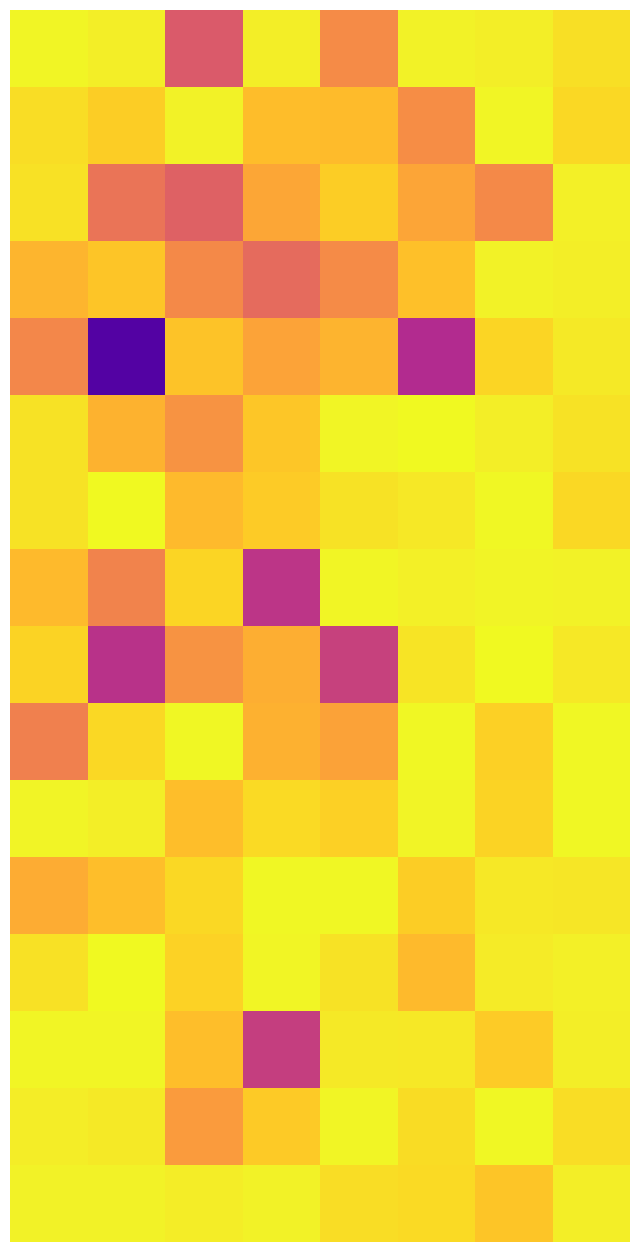

In [16]:
net.load_model("3D-ConvLSTMNet-BikeNYC")
rmse, mae,ypred,y= net.test_model(test_loader) 
y = [inverse_transform(d) for d in y]
ypred = [inverse_transform(d) for d in ypred]
plt.figure(figsize=(8,16))
sns.heatmap(data=abs(ypred[18][0]-y[18][0]),vmax=40,square=False,cbar=False, xticklabels=False,yticklabels=False,cmap="plasma_r")